In [1]:
from typing import TypedDict, List, Dict, Any, Literal, Callable, NamedTuple
import json
from pydantic import BaseModel, Field
import random
from langgraph.graph import StateGraph, END
from openai import OpenAI
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import notebook
from tenacity import retry, stop_after_attempt, wait_exponential


In [4]:
client = OpenAI()

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=2, max=10))
def llm_call(system_prompt: str, prompt: str, OutputFormat: BaseModel, temperature=0.7, model: str = "gpt-4o"):
    llm_out = client.responses.parse(
        temperature=temperature,
        model=model,
        input=[{"role": "system", "content": system_prompt},
               {"role": "user", "content": prompt}],
        text_format=OutputFormat,
    )
    llm_out = llm_out.output_parsed
    return llm_out

In [5]:
train = pd.read_csv("Train.csv")

In [6]:
# Configuration
MAX_ITERATIONS = 20
TARGET_SCORE = 0.99

# Available improvement actions
IMPROVEMENT_ACTIONS = [
    "Add examples: This is pertaining to few-shot prompting. Try not to add examples directly from the feedback. Instead, create new examples that are similar in nature to the feedback.",
    "Remove examples: If the current examples are not helpful, consider removing them.",
    "Add Chain of Thought reasoning: You can ask the model to think step-by-step, and output its reasoning. This may or may not improve the performance. You should consider removing it if it degrades the performance.",
    "Remove Chain of Thought reasoning: If the current prompt includes chain of thought reasoning, consider removing it.",
    "Add specificity: A prompt or any aspect of a prompt can be more or less specific.",
    "Remove specificity: A prompt or any aspect of a prompt can be more or less specific.",
    "Change wording: Rephrase parts of the prompt to improve clarity or effectiveness.",
    "Add context: Context can be added or removed to provide more or less information to the model.",
    "Remove context: Context can be added or removed to provide more or less information to the model.",
    "Break the problem into subtasks: Consider breaking a complex problem into smaller, manageable subtasks, or consolidating subtasks into a single task if appropriate.",
    "Define roles: Clearly specify the role the model should assume when generating a response.",
    "Remove roles: Clearly specify the role the model should assume when generating a response.",
    "Add constraints: Introduce constraints to guide the model's responses more effectively.",
    "Remove constraints: Introduce constraints to guide the model's responses more effectively.",
    "Ask for alternatives: Encourage the model to explore alternative solutions or perspectives.",
    "Include negative examples: Provide examples of undesirable responses to help the model learn from mistakes.",
    "Add verification steps: Include steps for the model to verify its own answers.",
    "Remove verification steps: If the prompt includes verification steps, consider removing them.",
    "Add specifying thinking style: Instruct the model on the preferred style of reasoning or explanation.",
    "Add including edge cases: Encourage the model to consider edge cases in its responses.",
    "Remove including edge cases: If the prompt includes edge cases, consider removing them.",
    "Add quality criteria: Specify the criteria that the model's responses should meet.",
    "Remove quality criteria: If the prompt includes quality criteria, consider removing them.",
    "Add requesting explanations: Ask the model to explain its reasoning or thought process.",
    "Remove requesting explanations: If the prompt includes requesting explanations, consider removing them.",
    "Other: This is a catch-all for any other improvement action that may not fit the above categories.",
]

##############################################
# Epsilon-greedy strategy for prompt selection
##############################################

class PromptTemplateData(NamedTuple):
    prompt: str
    system_prompt: str
    prompt_format_function: Callable[[str], str] = lambda x: x
    output_format: BaseModel = None

# State definition
class PromptEngineerState(TypedDict):
    current_prompt: PromptTemplateData
    #evaluation_dataset: List[Dict[str, Any]]
    performance_metrics_string: str
    performance_metrics: Dict[str, float]
    failure_analysis: List[Dict[str, Any]]
    improvement_actions: List[str]
    iteration_count: int
    best_prompt: PromptTemplateData
    best_score: float
    search_history: List[Dict[str, Any]]
    selected_action: str
    epsilon_choice: str  # "explore" or "exploit"


class PromptOptimizer:
    def __init__(
        self,
        #failure_analysis: PromptTemplateData,
        action_selection: PromptTemplateData,
        action_application: PromptTemplateData,
        initial_prompt: PromptTemplateData,
        evaluation_method: Callable[[PromptTemplateData, List[Any]], Dict[str, float]],
        training_dataset: List[Any],
        action_list: List[str] = IMPROVEMENT_ACTIONS,
        train_test_ratio: float = 0.5,
        epsilon: float = 0.3,  # exploration rate
        epsilon_decay: float = 0.95,  # decay rate for epsilon
        min_epsilon: float = 0.1,  # minimum exploration rate
    ):
        #self.failure_analysis = failure_analysis
        self.action_selection = action_selection
        self.action_application = action_application
        self.action_list = action_list
        self.initial_prompt = initial_prompt
        self.evaluation_method = evaluation_method
        self.training_dataset, self.evaluation_dataset = train_test_split(
            training_dataset, test_size=1 - train_test_ratio, random_state=42
        )

        # Epsilon-greedy parameters
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Build the workflow
        self.workflow = StateGraph(PromptEngineerState)
        self.workflow.add_node("evaluate", self.evaluate_prompt_node)
        #self.workflow.add_node("analyze_failures", self.analyze_failures_node)
        self.workflow.add_node("epsilon_greedy_choice", self.epsilon_greedy_choice_node)
        self.workflow.add_node("select_action", self.select_action_node)
        self.workflow.add_node("apply_action", self.apply_action_node)

        #self.workflow.add_edge("evaluate", "analyze_failures")
        self.workflow.add_edge("evaluate", "epsilon_greedy_choice")
        self.workflow.add_edge("epsilon_greedy_choice", "select_action")
        self.workflow.add_edge("select_action", "apply_action")
        self.workflow.add_conditional_edges("apply_action", self.should_continue)
        self.workflow.set_entry_point("evaluate")
        self.app = self.workflow.compile()

    def evaluate_prompt_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print(f"current prompt: {state['current_prompt'].prompt}")
        print("========================================")
        print(f"🔍 Evaluating prompt (iteration {state['iteration_count']})")
        
        # Generate metrics
        metrics = self.evaluation_method(state["current_prompt"], self.training_dataset)
        validation_metrics = self.evaluation_method(state["current_prompt"], self.evaluation_dataset)
        accuracy = metrics.get("accuracy", 0)
        recall = metrics.get("recall", 0)
        precision = metrics.get("precision", 0)
        false_positive_rate = metrics.get("false_positive_rate", 0)
        # Calculate F1 score
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        # calculate f1 score for validation dataset
        if validation_metrics.get("precision", 0) + validation_metrics.get("recall", 0) > 0:
            validation_f1_score = 2 * (validation_metrics.get("precision", 0) * validation_metrics.get("recall", 0)) / (validation_metrics.get("precision", 0) + validation_metrics.get("recall", 0))
        else:
            validation_f1_score = 0
        # Extract failure cases
        if "failure_cases" in metrics:  # Ensure failure_cases is in metrics
            failure_cases = metrics["failure_cases"]
        else:
            failure_cases = []
        metrics = {
            "validation_accuracy": validation_metrics.get("accuracy", 0),
            "validation_recall": validation_metrics.get("recall", 0),
            "validation_precision": validation_metrics.get("precision", 0),
            "validation_f1_score": validation_f1_score,
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "f1_score": f1_score,
            "false_positive_rate": false_positive_rate,
            "failure_cases": "\n".join(failure_cases) if failure_cases else "None" # convert list to string to feed to the llm
        }
        
        # Track best prompt globally
        new_best_prompt = state["best_prompt"]
        new_best_score = state["best_score"]
        
        if validation_f1_score > state["best_score"]:
            new_best_prompt = state["current_prompt"]
            new_best_score = validation_f1_score
            print(f"🎉 New best score: {validation_f1_score:.3f}")

        #performance_metrics_string = ''
        #for item in metrics:
        #    performance_metrics_string += f"{item}:\n {metrics[item]}\n"
        
        performance_metrics_string = ''
        for item in metrics:
            performance_metrics_string += f"{item}:\n {metrics[item]}\n"
        
        return {
            **state,
            "performance_metrics_string": performance_metrics_string,
            "performance_metrics": metrics,
            "best_prompt": new_best_prompt,
            "best_score": new_best_score
        }

    def epsilon_greedy_choice_node(self, state: PromptEngineerState) -> PromptEngineerState:
        """Epsilon-greedy choice: continue current prompt with prob epsilon, or use best prompt with prob 1-epsilon"""
        current_epsilon = max(self.min_epsilon, self.epsilon * (self.epsilon_decay ** state["iteration_count"]))
        
        if random.random() < current_epsilon:
            # Explore: continue with current prompt
            print(f"🔍 Exploring - continuing with current prompt (ε={current_epsilon:.3f})")
            choice = "explore"
            chosen_prompt = state["current_prompt"]
        else:
            # Exploit: use best known prompt
            print(f"💰 Exploiting - using best known prompt (ε={current_epsilon:.3f})")
            choice = "exploit"
            chosen_prompt = state["best_prompt"] if state["best_prompt"] else state["current_prompt"]
        
        return {
            **state,
            "current_prompt": chosen_prompt,
            "epsilon_choice": choice
        }

    def select_action_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print("🤖 Selecting improvement action")
        
        metrics = state["performance_metrics"]
        
        # LLM based action selection
        random.shuffle(self.action_list) # We shuffle to debias the llm's potential location bias
        llm_action_output = llm_call(
            system_prompt=self.action_selection.system_prompt,
            prompt= self.action_selection.prompt_format_function(
            prompt = self.action_selection.prompt,
            current_prompt=state["current_prompt"].prompt,  # Extract the prompt string
            performance_metrics=json.dumps({k: v for k, v in metrics.items() if not k.startswith("validation_")}, indent=2),
            ),
            OutputFormat=self.action_selection.output_format,
        )

        selected_action = llm_action_output.action
        assert selected_action is not None, "LLM did not return a valid action. Please check the action selection prompt and the LLM response format."
        
        print(f"🎯 Selected action: {selected_action}")
        return {
            **state,
            "selected_action": selected_action
        }

    def apply_action_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print(f"⚡ Applying action: {state['selected_action']}")
        action = state["selected_action"]
        current_prompt = state["current_prompt"].prompt  # Extract the prompt string
        metrics = state["performance_metrics"]
        
        # Apply the selected action to modify the prompt
        llm_new_prompt_output = llm_call(
            system_prompt=self.action_application.system_prompt,
            prompt=self.action_application.prompt_format_function(
                prompt=self.action_application.prompt,
                selected_action=action,
                current_prompt=current_prompt,
                performance_metrics=json.dumps({k: v for k, v in metrics.items() if not k.startswith("validation_")}, indent=2),
            ),
            OutputFormat=self.action_application.output_format,
        )

        new_prompt_str = llm_new_prompt_output.new_prompt
        assert new_prompt_str is not None, "LLM did not return a valid new prompt. Please check the action application prompt and the LLM response format."

        # Create new PromptTemplateData object with the updated prompt
        new_prompt = PromptTemplateData(
            prompt=new_prompt_str,
            system_prompt=state["current_prompt"].system_prompt,
            output_format=state["current_prompt"].output_format,
            prompt_format_function=state["current_prompt"].prompt_format_function
        )

        new_history = state["search_history"] + [{
            "iteration": state["iteration_count"],
            "action": action,
            "prompt": new_prompt_str,
            "metrics": state["performance_metrics"], 
        }]

        print(f"iteration: {state['iteration_count']} | action: {action} | training f1_score: {state['performance_metrics']['f1_score']:.3f} | validation f1_score: {state['performance_metrics']['validation_f1_score']:.3f}")
        
        return {
            **state,
            "current_prompt": new_prompt,
            "iteration_count": state["iteration_count"] + 1,
            "search_history": new_history
        }

    def should_continue(self, state: PromptEngineerState) -> Literal["evaluate", "__end__"]:
        if state["iteration_count"] >= MAX_ITERATIONS:
            print(f"🛑 Max iterations ({MAX_ITERATIONS}) reached")
            return "__end__"
        if state["performance_metrics"]["f1_score"] >= TARGET_SCORE:
            print(f"🎯 Target score ({TARGET_SCORE}) achieved!")
            return "__end__"
        return "evaluate"

    def visualize(self):
        try:
            from IPython.display import Image, display
            display(Image(self.app.get_graph().draw_mermaid_png()))
        except ImportError:
            print("To visualize the graph, install: pip install grandalf")
            print("Or use: app.get_graph().print_ascii()")
            print("\nWorkflow Graph (ASCII):")
            self.app.get_graph().print_ascii()
    
    def run(self) -> PromptEngineerState:
        initial_state: PromptEngineerState = {
            "current_prompt": self.initial_prompt,
            "performance_metrics_string": "",
            "performance_metrics": {},
            "failure_analysis": [],
            "improvement_actions": [],
            "iteration_count": 0,
            "best_prompt": self.initial_prompt,
            "best_score": 0.0,
            "search_history": [],
            "selected_action": "",
            "epsilon_choice": ""
        }
        final_state = self.app.invoke(initial_state, {"recursion_limit": 100})
        return final_state

In [7]:


def evaluation_method(prompt: PromptTemplateData, dataset: pd.DataFrame) -> Dict[str, float]:
    # evaluation method for demonstration
    prediction = []
    for index, row in notebook.tqdm(dataset.iterrows(), total=len(dataset)):
        system_prompt = prompt.system_prompt
        formatted_prompt = prompt.prompt_format_function(prompt.prompt, row['text'])
        OutputFormat = prompt.output_format
        llm_response = llm_call(system_prompt=system_prompt, prompt=formatted_prompt, OutputFormat=OutputFormat, model="gpt-4o-mini")
        prediction.append(1 if llm_response.sentiment else 0)
    actual = dataset['label'].to_list()
    precision = sum(p == a == 1 for p, a in zip(prediction, actual)) / sum(p == 1 for p in prediction) if sum(p == 1 for p in prediction) > 0 else 0
    recall = sum(p == a == 1 for p, a in zip(prediction, actual)) / sum(a == 1 for a in actual) if sum(a == 1 for a in actual) > 0 else 0
    return {
        "accuracy": sum(p == a for p, a in zip(prediction, actual)) / len(actual),
        "recall": recall,
        "precision": precision,
        "f1_score": 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0,
        "false_positive_rate": sum(p == 1 and a == 0 for p, a in zip(prediction, actual)) / sum(a == 0 for a in actual) if sum(a == 0 for a in actual) > 0 else 0,
        "failure_cases": [f"text: {row['text']}| predicted: {prediction[i]}| actual: {row['label']}" for i, (index, row) in enumerate(dataset.iterrows()) if row['label'] != prediction[i]]
    }

In [8]:
# Define the output formats for LLM nodes
class ActionOutputFormat(BaseModel):
    """Output format for the action selection step."""
    cot: str = Field(..., description="Chain of thought reasoning for the selected action.")
    action: str = Field(..., description="The selected action to apply to the current prompt.")

class ActionApplicationOutputFormat(BaseModel):
    """Output format for the action application step."""
    cot: str = Field(..., description="Chain of thought reasoning for the action application.")
    new_prompt: str = Field(..., description="The new prompt after applying the selected action.")

class InitialPromptOutputFormat(BaseModel):
    """Output format for the initial prompt."""
    sentiment: bool = Field(..., description="sentiment analysis of the text either positive/True or negarive/False")
    other: str = Field(..., description="Everything else requested by the prompt in string format.")

initial_prompt=PromptTemplateData(
    prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
    system_prompt="You are an expert in extracting the comment sentiment from the given text.",
    output_format=InitialPromptOutputFormat,
    prompt_format_function=lambda x, y: x.format(text=y)
)



In [10]:
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial

# Function to process a single row for multiprocessing
def process_single_row(row_data, system_prompt, prompt_template, output_format, model):
    """Process a single row for LLM call - needs to be at module level for pickling"""
    index, row = row_data
    llm_response = llm_call(
        system_prompt=system_prompt,
        prompt=prompt_template.format(text=row['text']),
        OutputFormat=output_format,
        model=model
    )
    return index, row, llm_response

# creating a dataset where gpt-4o-mini performs poorly
bad_data = {'text': [], 'label': []}

# Prepare data for multiprocessing
rows_to_process = [(index, row) for index, row in train.iterrows()]
system_prompt = "You are an expert in extracting the comment sentiment from the given text."
prompt_template = "For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}"

# Create partial function with fixed parameters
process_func = partial(
    process_single_row,
    system_prompt=system_prompt,
    prompt_template=prompt_template,
    output_format=InitialPromptOutputFormat,
    model="gpt-4o-mini"
)

# Use multiprocessing with progress tracking
max_workers = min(mp.cpu_count(), 8)  # Adjust based on API rate limits
batch_size = 50  # Process in batches to avoid overwhelming the API

print(f"Using {max_workers} workers for parallel processing...")

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit batches of work
    futures = []
    for i in range(0, len(rows_to_process), batch_size):
        batch = rows_to_process[i:i + batch_size]
        batch_futures = [executor.submit(process_func, row_data) for row_data in batch]
        futures.extend(batch_futures)
        
        # Process completed futures from this batch
        for future in as_completed(batch_futures):
            try:
                index, row, llm_response = future.result()
                if llm_response.sentiment != (row['label'] == 1):
                    bad_data['text'].append(row['text'])
                    bad_data['label'].append(row['label'])
                
                # Break early if we have enough bad examples
                if len(bad_data['text']) >= 100:
                    # Cancel remaining futures
                    for f in futures:
                        f.cancel()
                    break
                    
            except Exception as e:
                print(f"Error processing row {index}: {e}")
        
        # Break if we have enough data
        if len(bad_data['text']) >= 100:
            break
        
        print(f"Processed batch {i//batch_size + 1}, found {len(bad_data['text'])} bad examples so far...")

training_dataset = pd.DataFrame(bad_data)
print(f"Created training dataset with {len(training_dataset)} examples")

Using 8 workers for parallel processing...
Processed batch 1, found 3 bad examples so far...
Processed batch 2, found 7 bad examples so far...
Processed batch 3, found 11 bad examples so far...
Processed batch 4, found 12 bad examples so far...
Processed batch 5, found 16 bad examples so far...
Processed batch 6, found 19 bad examples so far...
Processed batch 7, found 20 bad examples so far...
Processed batch 8, found 22 bad examples so far...
Processed batch 9, found 24 bad examples so far...
Processed batch 10, found 28 bad examples so far...
Processed batch 11, found 31 bad examples so far...
Processed batch 12, found 35 bad examples so far...
Processed batch 13, found 38 bad examples so far...
Processed batch 14, found 42 bad examples so far...
Processed batch 15, found 49 bad examples so far...
Processed batch 16, found 51 bad examples so far...
Processed batch 17, found 56 bad examples so far...
Processed batch 18, found 60 bad examples so far...
Processed batch 19, found 67 bad

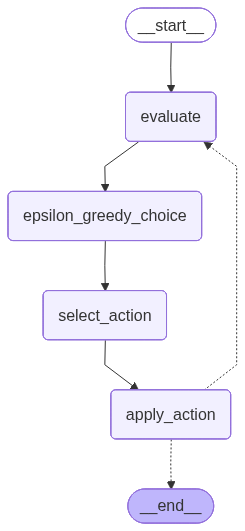

In [14]:
# Initialize the PromptOptimizer with the initial prompt and evaluation method
po = PromptOptimizer(
    evaluation_method=evaluation_method,     # evaluation method for demonstration
    training_dataset=training_dataset,
    action_selection=PromptTemplateData(
        prompt="""Select an improvement action based on failure analysis: 
        Task:
        Sentiment analysis of movie reviews. If the movie review is positive, return true, otherwise return false.
        Current Prompt:
        {current_prompt}
        Performance Metrics:
        {performance_metrics}
        """,
        system_prompt=f"""You are an expert prompt engineer. Your task is to optimize prompts for the given task.
        You will be provided with a current prompt, performance metrics for the task, and a set of improvement actions.
        Your goal is to iteratively improve the prompt based on performance metrics and failure analysis.
        You will select an action to apply to the current prompt. A separate step will apply that action to generate a new prompt.
        Note that these actions will be used later to modify the prompt that an LLM will use to perform the task.
        The purpose of the afformentioned prompt is sentiment analysis of movie reviews.
        When choosing an action, consider the performance metrics and failure cases. You should think about why the model is failing on the specific failure cases provided and suggest an action accordingly.
        Improvement actions you can choose from are:
        {', '.join(IMPROVEMENT_ACTIONS)}
        """,
        output_format=ActionOutputFormat,
        prompt_format_function=lambda **kwargs: kwargs['prompt'].format(**{k: v for k, v in kwargs.items() if k != 'prompt'})
    ),
    action_application=PromptTemplateData(
        prompt="""Apply the selected action to the prompt for the following task, and performance metrics:
        Task:
        Sentiment analysis of movie reviews. If the movie review is positive, return true, otherwise return false.
        prompt: 
        {selected_action} 
        Current Prompt: 
        {current_prompt}
        Performance Metrics:
        {performance_metrics}""",
        system_prompt=f"""You are a prompt engineer. 
        You are provided with a prompt which you will help improve such that an llm performs well on a given task. 
        Your job is to improve a prompt based on a preselection improvement action and a set of existing performance metrics performance metrics.
        You should provide the new prompt that results from applying the action that you are provided with to the current prompt.
        Make sure the new prompt is clear, concise, and effectively incorporates the selected improvement action.
        Do not change any other aspect of the prompt except for applying the selected improvement action.
        when applying the action, consider the performance metrics and failure cases. You should think about why the model is failing on the specific failure cases provided and modify the prompt accordingly.
        The improvement action you will be provided with will be one of the following: {', '.join(IMPROVEMENT_ACTIONS)}""",
        output_format=ActionApplicationOutputFormat,
        prompt_format_function=lambda **kwargs: kwargs['prompt'].format(**{k: v for k, v in kwargs.items() if k != 'prompt'})
    ),
    initial_prompt=PromptTemplateData(
        prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
        system_prompt="You are an expert in extracting the comment sentiment from the given text.",
        output_format=InitialPromptOutputFormat,
        prompt_format_function=lambda x, y: x.format(text=y)
    ),
    action_list=IMPROVEMENT_ACTIONS,
    train_test_ratio=0.5,
)

po.visualize()

In [15]:

final_state = po.run()

current prompt: For the following given text return true if the sentiment is positive, otherwise return false. 
Text: {text}
🔍 Evaluating prompt (iteration 0)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

🎉 New best score: 0.077
🔍 Exploring - continuing with current prompt (ε=0.300)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 0 | action: Add examples | training f1_score: 0.115 | validation f1_score: 0.077
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Text: {text}
🔍 Evaluating prompt (iteration 1)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

🎉 New best score: 0.218
💰 Exploiting - using best known prompt (ε=0.285)
🤖 Selecting improvement action
🎯 Selected action: Add context
⚡ Applying action: Add context
iteration: 1 | action: Add context | training f1_score: 0.231 | validation f1_score: 0.218
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Tex

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

🎉 New best score: 0.226
💰 Exploiting - using best known prompt (ε=0.271)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 2 | action: Add examples | training f1_score: 0.235 | validation f1_score: 0.226
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.257)
🤖 Selecting improvement action
🎯 Selected action: Add Chain of Thought reasoning
⚡ Applying action: Add Chain of Thought reasoning
iteration: 3 | action: Add Chain of Thought reasoning | training f1_score: 0.160 | validation f1_score: 0.192
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

🎉 New best score: 0.291
💰 Exploiting - using best known prompt (ε=0.244)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 4 | action: Add examples | training f1_score: 0.235 | validation f1_score: 0.291
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.232)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 5 | action: Add examples | training f1_score: 0.170 | validation f1_score: 0.192
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Example 5:
Text: The fil

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.221)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 6 | action: Add examples | training f1_score: 0.235 | validation f1_score: 0.226
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Example 5:
Text: The fil

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

🎉 New best score: 0.345
💰 Exploiting - using best known prompt (ε=0.210)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 7 | action: Add examples | training f1_score: 0.302 | validation f1_score: 0.345
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

🔍 Exploring - continuing with current prompt (ε=0.199)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 8 | action: Add examples | training f1_score: 0.357 | validation f1_score: 0.291
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Example 5:
Text: T

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.189)
🤖 Selecting improvement action
🎯 Selected action: Add specificity
⚡ Applying action: Add specificity
iteration: 9 | action: Add specificity | training f1_score: 0.302 | validation f1_score: 0.291
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment. A positive sentiment should include expressions of enthusiasm, satisfaction, or high praise for these aspects. If the review predominantly reflects these positive elements, return true. Otherwise, return false.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed ev

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.180)
🤖 Selecting improvement action
🎯 Selected action: Ask for alternatives
⚡ Applying action: Ask for alternatives
iteration: 10 | action: Ask for alternatives | training f1_score: 0.275 | validation f1_score: 0.264
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral. Explore alternative interpretations of the sentiment to ensure a balanced judgment.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few goo

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.171)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 11 | action: Add examples | training f1_score: 0.379 | validation f1_score: 0.316
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Example 5:
Text: The fi

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.162)
🤖 Selecting improvement action
🎯 Selected action: Add quality criteria
⚡ Applying action: Add quality criteria
iteration: 12 | action: Add quality criteria | training f1_score: 0.213 | validation f1_score: 0.264
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral. Ensure the output meets the following quality criteria: 1. Positive sentiment must reflect a majority of positive opinions on major aspects like acting, plot, and direction. 2. Negative sentiment should be evident if negative aspects outweigh the positive ones. 3. Neutral sentiment is not considered positive and should return false.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: t

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.154)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 13 | action: Add examples | training f1_score: 0.217 | validation f1_score: 0.231
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Example 5:
Text: The fi

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.146)
🤖 Selecting improvement action
🎯 Selected action: Ask for alternatives
⚡ Applying action: Ask for alternatives
iteration: 14 | action: Ask for alternatives | training f1_score: 0.357 | validation f1_score: 0.296
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on various aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral. Additionally, explore alternative interpretations of the sentiment, especially for reviews that are ambiguous or mixed in nature.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute o

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.139)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 15 | action: Add examples | training f1_score: 0.321 | validation f1_score: 0.255
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Example 5:
Text: The fi

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.132)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 16 | action: Add examples | training f1_score: 0.308 | validation f1_score: 0.321
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Example 5:
Text: The fi

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.125)
🤖 Selecting improvement action
🎯 Selected action: Add constraints
⚡ Applying action: Add constraints
iteration: 17 | action: Add constraints | training f1_score: 0.235 | validation f1_score: 0.222
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral. Ensure that the overall impression of the review is positive before returning true, even if some individual aspects are praised.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Exam

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.119)
🤖 Selecting improvement action
🎯 Selected action: Add constraints
⚡ Applying action: Add constraints
iteration: 18 | action: Add constraints | training f1_score: 0.296 | validation f1_score: 0.286
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Consider that movie reviews often express opinions on aspects such as acting, plot, direction, and overall enjoyment, which can be positive, negative, or neutral.

Example 1:
Text: This movie was an absolute delight with stunning visuals and a captivating plot that kept me engaged.
Output: true

Example 2:
Text: I found the film quite boring and it didn't hold my interest at all.
Output: false

Example 3:
Text: The performances were outstanding, and I thoroughly enjoyed every minute of it.
Output: true

Example 4:
Text: Despite a few good moments, the movie was largely disappointing and not worth my time.
Output: false

Example 5:
Tex

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.113)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 19 | action: Add examples | training f1_score: 0.264 | validation f1_score: 0.231
🛑 Max iterations (20) reached


In [ ]:
final_state

{'current_prompt': PromptTemplateData(prompt='For the following given text, analyze the sentiment expressed in the review, breaking down the evaluation step-by-step. Consider the tone, language, and specific phrases used. Return true if the overall sentiment is positive, otherwise return false.\nText: {text}', system_prompt='You are an expert in extracting the comment sentiment from the given text.', prompt_format_function=<function <lambda> at 0x7a0ecc97dc60>, output_format=<class '__main__.InitialPromptOutputFormat'>),
 'performance_metrics_string': 'validation_accuracy:\n 0.8933333333333333\nvalidation_recall:\n 0.8735632183908046\nvalidation_precision:\n 0.9382716049382716\nvalidation_f1_score:\n 0.9047619047619048\naccuracy:\n 0.9533333333333334\nrecall:\n 0.9444444444444444\nprecision:\n 0.9577464788732394\nf1_score:\n 0.951048951048951\nfalse_positive_rate:\n 0.038461538461538464\nfailure_cases:\n text: I give the show a six because of the fact that the show was in fact a platfo